<h1>Transfer Learning with ResNet50 on MNIST Dataset</h1>

<h2>Memory-Efficient Alternative to VGG16</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>transfer learning using ResNet50</b> on MNIST dataset. ResNet50 is significantly more memory-efficient than VGG16 (~25M vs ~138M parameters), making it ideal for resource-constrained environments.</p>

<h4>Key Components:</h4>
<ul>
  <li><b>Pre-trained Model:</b> ResNet50 with ImageNet weights</li>
  <li><b>Frozen Layers:</b> Base model features frozen for transfer learning</li>
  <li><b>Global Average Pooling:</b> Replaces Flatten+Dense (MANDATORY)</li>
  <li><b>Custom Head:</b> Dense(128) + Dropout + Dense(10)</li>
  <li><b>Batch Processing:</b> Memory-efficient image resizing</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Apply transfer learning with pre-trained ResNet50</li>
  <li>✓ Handle grayscale to RGB conversion for MNIST</li>
  <li>✓ Use Global Average Pooling for efficiency</li>
  <li>✓ Compare ResNet50 vs VGG16 memory footprint</li>
  <li>✓ Freeze base layers and train custom classifier</li>
</ul>

<hr>

<h3>Architecture</h3>
<pre>
ResNet50 Features (frozen, ImageNet weights)
   ↓
GlobalAveragePooling2D  [GAP - MANDATORY]
   ↓
Dense (128) + ReLU + Dropout(0.5)
   ↓
Dense (10) + Softmax
</pre>

In [1]:
# Import Libraries 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU to avoid GPU errors

# Then imports 
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
import random
from PIL import Image

2026-01-13 10:13:16.692860: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-13 10:13:16.693460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 10:13:16.738053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 10:13:18.270893: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### PART 1: LOAD AND PREPROCESS MNIST DATASET

In [3]:
print("\n[1] Loading MNIST dataset...")
mnist = tf.keras.datasets.mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

print(f"Original shapes - Train: {Xtrain.shape}, Test: {Xtest.shape}")

# Convert grayscale to RGB (repeat channel 3 times)
# ResNet50 expects 3-channel input
Xtrain_rgb = np.repeat(Xtrain[..., np.newaxis], 3, axis=-1)
Xtest_rgb = np.repeat(Xtest[..., np.newaxis], 3, axis=-1)

print(f"After RGB conversion - Train: {Xtrain_rgb.shape}, Test: {Xtest_rgb.shape}")



[1] Loading MNIST dataset...
Original shapes - Train: (60000, 28, 28), Test: (10000, 28, 28)
After RGB conversion - Train: (60000, 28, 28, 3), Test: (10000, 28, 28, 3)


In [4]:
# Resize images function with batch processing for memory efficiency
def resize_images_batch(images, target_size=(48, 48), batch_size=1000):
    """
    Resize images in batches to avoid memory overflow
    ResNet50 minimum input: 32x32, using 48x48 for better results
    """
    resized = []
    n_images = len(images)
    
    for i in range(0, n_images, batch_size):
        batch_end = min(i + batch_size, n_images)
        batch = images[i:batch_end]
        
        batch_resized = np.zeros((len(batch), target_size[0], target_size[1], 3))
        for j, img in enumerate(batch):
            pil_img = Image.fromarray(img.astype('uint8'))
            pil_img = pil_img.resize(target_size)
            batch_resized[j] = np.array(pil_img)
        
        resized.append(batch_resized)
        
        if (i // batch_size) % 5 == 0:
            print(f"  Processed {batch_end}/{n_images} images...")
    
    return np.vstack(resized)



In [5]:
print("\n[2] Resizing images to 48x48 (batch processing for memory efficiency)...")

# USE SUBSET OF DATA for memory efficiency
print("Using subset of data to avoid memory exhaustion...")
train_subset = 10000  # Use only 10,000 training samples
test_subset = 2000    # Use only 2,000 test samples

Xtrain_rgb_subset = Xtrain_rgb[:train_subset]
Ytrain_subset = Ytrain[:train_subset]
Xtest_rgb_subset = Xtest_rgb[:test_subset]
Ytest_subset = Ytest[:test_subset]

print(f"Using {train_subset} training samples and {test_subset} test samples")

# Resize with smaller batch size
Xtrain_resized = resize_images_batch(Xtrain_rgb_subset, (48, 48), batch_size=100)
Xtest_resized = resize_images_batch(Xtest_rgb_subset, (48, 48), batch_size=100)

# Normalize to [0, 1]
Xtrain_resized = Xtrain_resized / 255.0
Xtest_resized = Xtest_resized / 255.0

# Convert labels to categorical
Ytrain_cat = to_categorical(Ytrain_subset, 10)
Ytest_cat = to_categorical(Ytest_subset, 10)

print(f"Final shapes - Train: {Xtrain_resized.shape}, Test: {Xtest_resized.shape}")
print(f"Label shapes - Train: {Ytrain_cat.shape}, Test: {Ytest_cat.shape}")


[2] Resizing images to 48x48 (batch processing for memory efficiency)...
Using subset of data to avoid memory exhaustion...
Using 10000 training samples and 2000 test samples
  Processed 100/10000 images...
  Processed 600/10000 images...
  Processed 1100/10000 images...
  Processed 1600/10000 images...
  Processed 2100/10000 images...
  Processed 2600/10000 images...
  Processed 3100/10000 images...
  Processed 3600/10000 images...
  Processed 4100/10000 images...
  Processed 4600/10000 images...
  Processed 5100/10000 images...
  Processed 5600/10000 images...
  Processed 6100/10000 images...
  Processed 6600/10000 images...
  Processed 7100/10000 images...
  Processed 7600/10000 images...
  Processed 8100/10000 images...
  Processed 8600/10000 images...
  Processed 9100/10000 images...
  Processed 9600/10000 images...
  Processed 100/2000 images...
  Processed 600/2000 images...
  Processed 1100/2000 images...
  Processed 1600/2000 images...
Final shapes - Train: (10000, 48, 48, 3)

### PART 2: LOAD PRE-TRAINED ResNet50 MODEL

In [7]:
print("\n[3] Loading pre-trained ResNet50 model...")
print("NOTE: ResNet50 is more memory-efficient than VGG16")
print(f"      ResNet50: ~25M parameters vs VGG16: ~138M parameters")

base_model = ResNet50(
    weights='imagenet',
    include_top=False,  # Exclude the final classification layer
    input_shape=(48, 48, 3)
)

# Freeze base model layers (transfer learning)
base_model.trainable = False

print(f"Base model loaded: {len(base_model.layers)} layers")
print(f"Base model trainable: {base_model.trainable}")
print(f"Total base parameters: {base_model.count_params():,}")



[3] Loading pre-trained ResNet50 model...
NOTE: ResNet50 is more memory-efficient than VGG16
      ResNet50: ~25M parameters vs VGG16: ~138M parameters


2026-01-13 10:14:02.799124: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Base model loaded: 175 layers
Base model trainable: False
Total base parameters: 23,587,712


### PART 3: BUILD TRANSFER LEARNING MODEL WITH GAP

In [8]:
print("\n[4] Building transfer learning model with Global Average Pooling...")

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # MANDATORY: Replace Flatten
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {model.count_params() - trainable_params:,}")



[4] Building transfer learning model with Global Average Pooling...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Total parameters: 23,851,274
Trainable parameters: 263,562
Frozen parameters: 23,587,712


### PART 4: TRAIN MODEL

In [9]:
print("\n[5] Training transfer learning model...")
print("Using small batch size for memory efficiency...")

# Train with reduced batch size and subset of data for memory efficiency
history = model.fit(
    Xtrain_resized,
    Ytrain_cat,
    batch_size=32,  # Small batch size for memory
    epochs=5,       # Few epochs for demonstration
    validation_split=0.1,
    verbose=1
)

print("\nTraining completed!")



[5] Training transfer learning model...
Using small batch size for memory efficiency...
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 270s 946ms/step - accuracy: 0.5921 - loss: 1.2189 - val_accuracy: 0.8170 - val_loss: 0.6245
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 266s 945ms/step - accuracy: 0.7653 - loss: 0.7252 - val_accuracy: 0.8620 - val_loss: 0.4442
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 266s 942ms/step - accuracy: 0.8112 - loss: 0.5941 - val_accuracy: 0.8850 - val_loss: 0.3718
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 938ms/step - accuracy: 0.8428 - loss: 0.5105 - val_accuracy: 0.8980 - val_loss: 0.3106
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 264s 937ms/step - accuracy: 0.8518 - loss: 0.4701 - val_accuracy: 0.9010 - val_loss: 0.2879

Training completed!


In [10]:
# Track initial and final loss
initial_loss = history.history['loss'][0]
final_loss = history.history['loss'][-1]

print(f"\nInitial training loss: {initial_loss:.4f}")
print(f"Final training loss:   {final_loss:.4f}")


Initial training loss: 1.2189
Final training loss:   0.4701


### PART 5: EVALUATE MODEL

In [11]:
print("\n[6] Evaluating model on test set...")

# Predict
Ytest_pred = model.predict(Xtest_resized, batch_size=32)
Ytest_pred_classes = np.argmax(Ytest_pred, axis=1)
Ytest_true = np.argmax(Ytest_cat, axis=1)

# Calculate metrics
accuracy = accuracy_score(Ytest_true, Ytest_pred_classes)
precision = precision_score(Ytest_true, Ytest_pred_classes, average='macro')
recall = recall_score(Ytest_true, Ytest_pred_classes, average='macro')
f1 = f1_score(Ytest_true, Ytest_pred_classes, average='macro')

print("\nRESNET50 TRANSFER LEARNING PERFORMANCE")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


[6] Evaluating model on test set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 860ms/step

RESNET50 TRANSFER LEARNING PERFORMANCE
Accuracy:  0.8825
Precision: 0.8846
Recall:    0.8793
F1-Score:  0.8784


### PART 6: VISUALIZATIONS


[7] Generating visualizations...


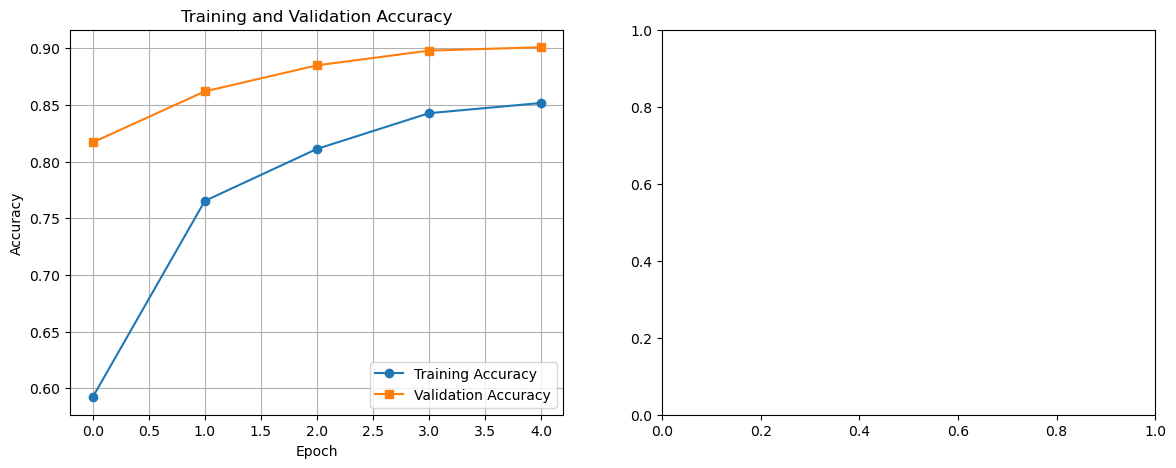

In [12]:
print("\n[7] Generating visualizations...")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].legend()
axes[0].grid(True)

In [13]:
# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

<Figure size 640x480 with 0 Axes>

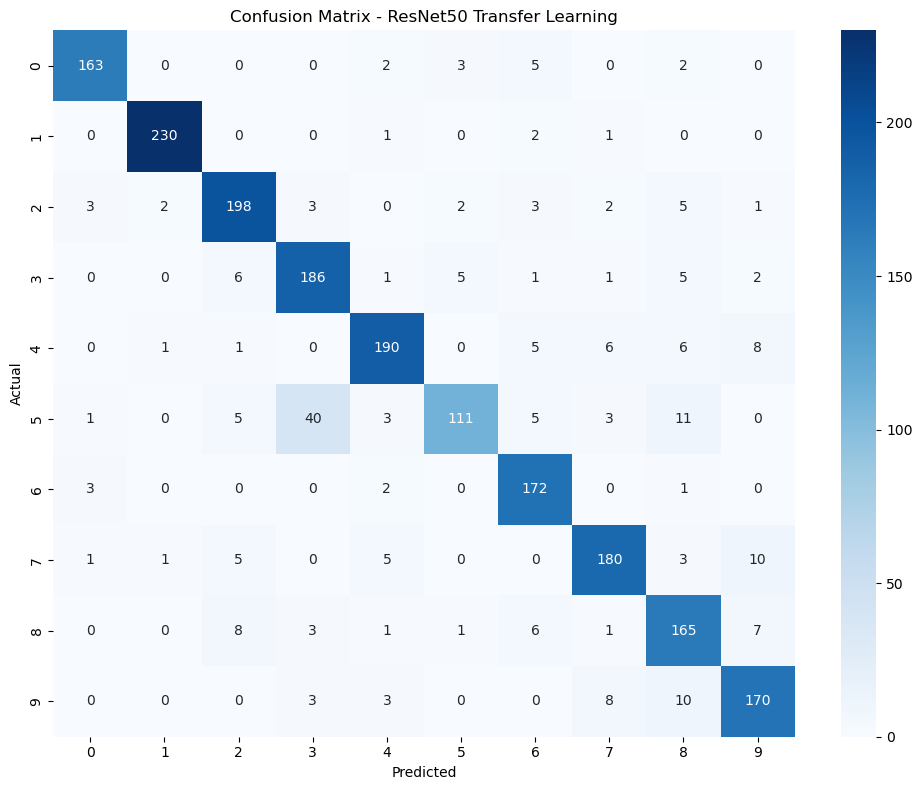

In [14]:
# Confusion Matrix
cm = confusion_matrix(Ytest_true, Ytest_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ResNet50 Transfer Learning')
plt.tight_layout()

In [15]:
print("Classification Report:")
print("\n", classification_report(Ytest_true, Ytest_pred_classes, 
                                  target_names=[str(i) for i in range(10)]))



Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.93      0.94       175
           1       0.98      0.98      0.98       234
           2       0.89      0.90      0.90       219
           3       0.79      0.90      0.84       207
           4       0.91      0.88      0.89       217
           5       0.91      0.62      0.74       179
           6       0.86      0.97      0.91       178
           7       0.89      0.88      0.88       205
           8       0.79      0.86      0.82       192
           9       0.86      0.88      0.87       194

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000



### PART 7: SAMPLE PREDICTIONS

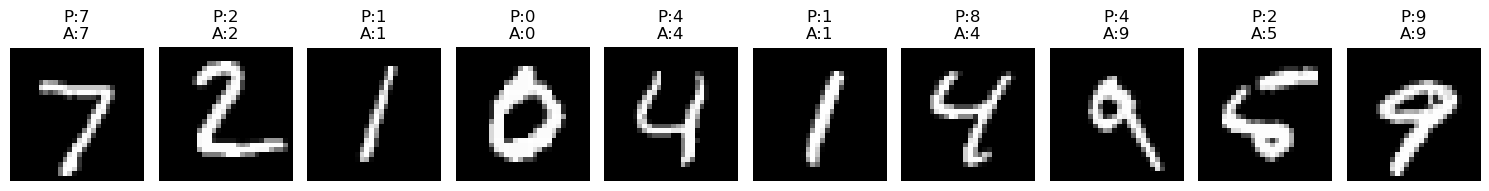

In [16]:
# Sample predictions
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(Xtest[i], cmap='gray')
    plt.title(f"P:{Ytest_pred_classes[i]}\nA:{Ytest[i]}")
    plt.axis('off')
plt.tight_layout()

In [17]:
print("\nTRANSFER LEARNING WITH RESNET50 COMPLETE")
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Model: ResNet50 (ImageNet weights)")
print(f"Dataset: MNIST (48x48 RGB)")
print(f"Framework: TensorFlow {tf.__version__}")


TRANSFER LEARNING WITH RESNET50 COMPLETE
Final Test Accuracy: 0.8825
Model: ResNet50 (ImageNet weights)
Dataset: MNIST (48x48 RGB)
Framework: TensorFlow 2.20.0


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Experiments</h3>

<h4>1. Model Architecture Variations</h4>
<ul>
  <li><b>Try other architectures:</b> MobileNetV2 (even lighter), EfficientNet, DenseNet</li>
  <li><b>Fine-tuning:</b> Unfreeze top layers of ResNet50 for better accuracy</li>
  <li><b>Different pooling:</b> GlobalMaxPooling2D vs GlobalAveragePooling2D</li>
  <li><b>Deeper classifier:</b> Add more Dense layers in custom head</li>
</ul>

<h4>2. Training Optimizations</h4>
<ul>
  <li><b>Learning rate scheduling:</b> ReduceLROnPlateau, cosine decay</li>
  <li><b>Data augmentation:</b> Rotation, shifting, zoom for MNIST</li>
  <li><b>Larger input size:</b> Try 96x96 or 128x128 for better features</li>
  <li><b>More epochs:</b> Train for 20-30 epochs with early stopping</li>
</ul>

<h4>3. Advanced Techniques</h4>
<ul>
  <li><b>Progressive unfreezing:</b> Gradually unfreeze ResNet50 layers</li>
  <li><b>Mixed precision:</b> Use FP16 for faster training</li>
  <li><b>Ensemble models:</b> Combine ResNet50 + VGG16 predictions</li>
</ul>

<h4>4. Different Datasets</h4>
<ul>
  <li>Fashion-MNIST (same preprocessing)</li>
  <li>CIFAR-10 (32x32 RGB - resize to 48x48)</li>
  <li>Cats vs Dogs (real RGB images)</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Achieve <b>>99% accuracy</b> on MNIST test set</li>
  <li>Compare <b>ResNet50 vs VGG16 vs MobileNetV2</b> performance</li>
  <li>Implement <b>fine-tuning</b> - unfreeze last 10 layers</li>
</ol>

<hr>
<h4><center>Happy coding!</center></h4>